In [3]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import gensim
import numpy as np
import json
from brand.debiasing import EmbeddingDebias
from brand.utils import get_embedding_mat, get_word_vector

# load definition words
gender_cfg_file = '../vocab/gender.json'
with open(gender_cfg_file, 'r') as f:
    cfg = json.load(f)
    gender_ds = cfg['definite_sets']

race_cfg_file = '../vocab/race.json'
with open(race_cfg_file, 'r') as f:
    cfg = json.load(f)
    race_ds = cfg['definite_sets']

In [5]:
# load word vector model
pretrained_embedding_file = '../data/GoogleNews-vectors-negative300.bin.gz'
kv = gensim.models.KeyedVectors.load_word2vec_format(pretrained_embedding_file, binary=True, limit=500000)

In [7]:
# prepare definitial (direction) matrix
gender_dmat = []
for _, words in enumerate(gender_ds):
    mat = get_embedding_mat(words, kv)
    gender_dmat.append(np.asarray(mat))

race_dmat = []
for _, words in enumerate(race_ds):
    mat = get_embedding_mat(words, kv)
    race_dmat.append(np.asarray(mat))

In [9]:
# create two debiasing workers
method = 'Hard'
k = 1
gender_debias = EmbeddingDebias(gender_dmat, embedding=kv, k=k, method=method)
race_debias = EmbeddingDebias(race_dmat, embedding=kv, k=k, method=method)

In [11]:
# dot product between two direction vectors
print('Dot product between two directions:', gender_debias._B.reshape(-1,).dot(race_debias._B.reshape(-1,)))

Dot product between two directions: 0.018920083


In [13]:
# brand list:
brands_China = ['Lenovo', 'Huawei', 'Alibaba', 'Lining', 'Anta', 'Haier', 'Hisense', 'Netease', 'Baidu', 'Sina']
brands_US = ['Google', 'Apple',  'Amazon', 'Microsoft', 'Marlboro', 'Outlier', 'Reformation','Pacifica', 'Sephora', 'Zippo', 'Cartier', 'UGG']

# check whether these words has pre-trained embeddings in w2vNews
for brand in brands_China+brands_US:
    try:
        embedding = kv[brand]
    except:
        print('{} not found.'.format(brand))
        continue

In [15]:
# project onto the gender-country plane
brands = brands_China + brands_US
_, mean = get_embedding_mat(brands, kv, mean=True)

gender_direction = gender_debias._B.reshape(-1,)
race_direction = race_debias._B.reshape(-1,)
c_gender = []
c_race = []
for brand in brands:
    coordinate_gender = get_word_vector(brand, kv, mean).dot(gender_direction)
    coordiante_race = get_word_vector(brand, kv, mean).dot(race_direction)
    c_gender.append(coordinate_gender)
    c_race.append(coordiante_race)
print(c_gender)
print(c_race)

[0.07047207, -0.3708894, 0.05607707, -0.33665416, -0.29115945, -0.15549654, -0.19084011, -0.0386585, 0.113841936, 0.118801445, 0.16688912, -0.032072615, 0.40479356, -0.108087435, -0.2588839, -0.15374503, -0.06145732, 0.022524446, 0.72377574, -0.2690172, 0.25608873, 0.33369744]
[0.14597955, -0.019227237, 0.40388024, -0.06275923, 0.060666993, -0.15197442, -0.2206673, 0.6273949, 0.27479035, 0.21597606, 0.025649652, 0.05695176, 0.16242002, 0.088660575, -0.58076, -0.18343979, -0.2192039, -0.14907423, 0.1035113, -0.24791606, -0.22500826, -0.105850816]


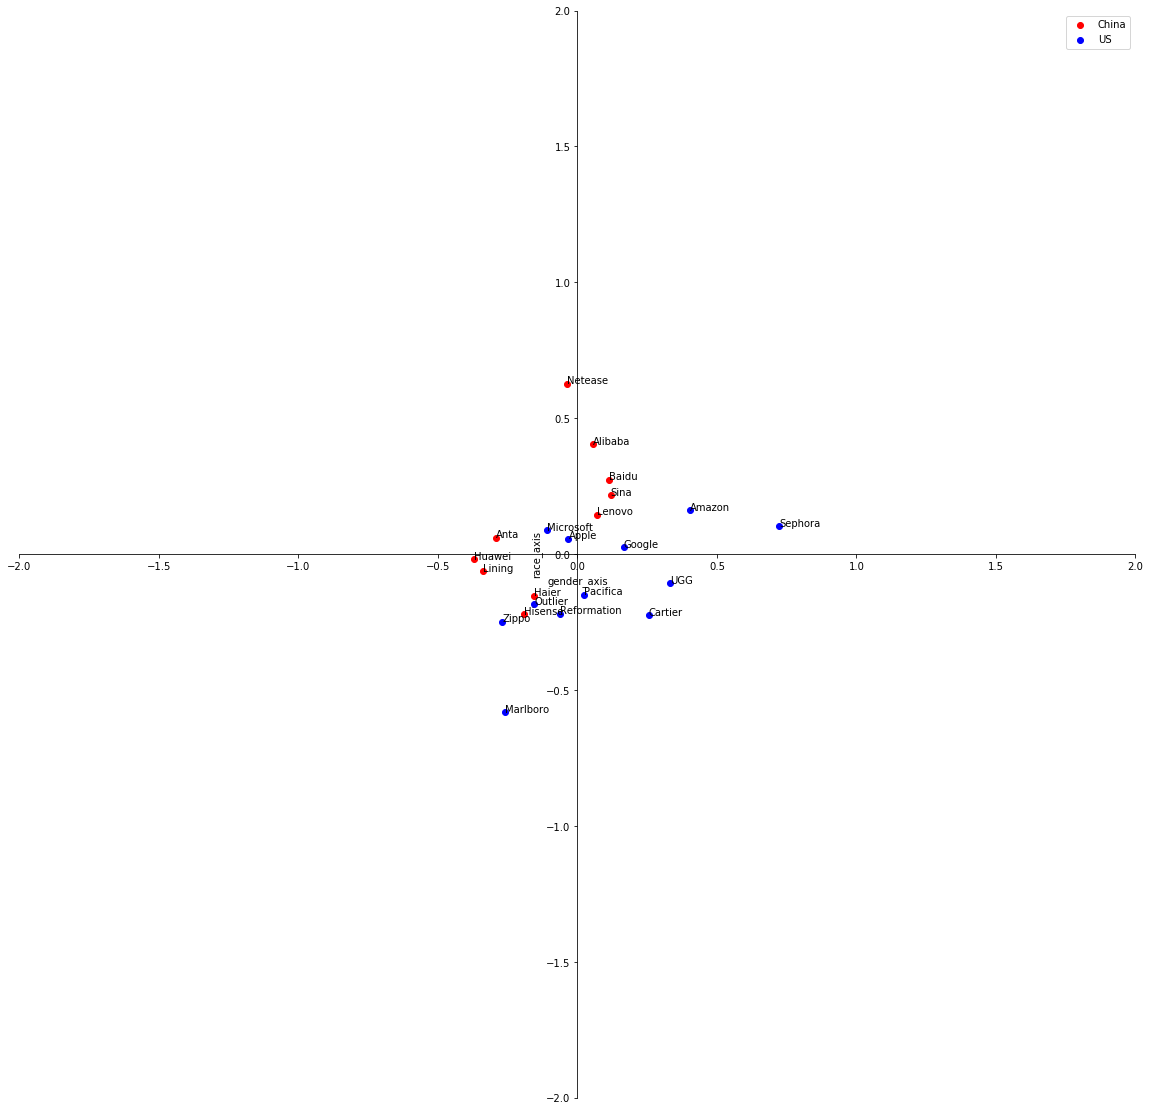

In [17]:
# plot on the gender-country 2D plane
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('gender_axis')
ax.set_ylabel('race_axis')
#split = len(brands_China)
ax.scatter(x=c_gender, y=c_race, c='b')
#ax.scatter(x=c_gender[split:], y=c_race[split:], c='b', label='US')
brands = brands_China + brands_US
for i, brand in enumerate(brands):
    ax.annotate(brand, (c_gender[i], c_race[i]))
#ax.legend()
fig.savefig('../figures/gender_vs_race.png')
plt.show()

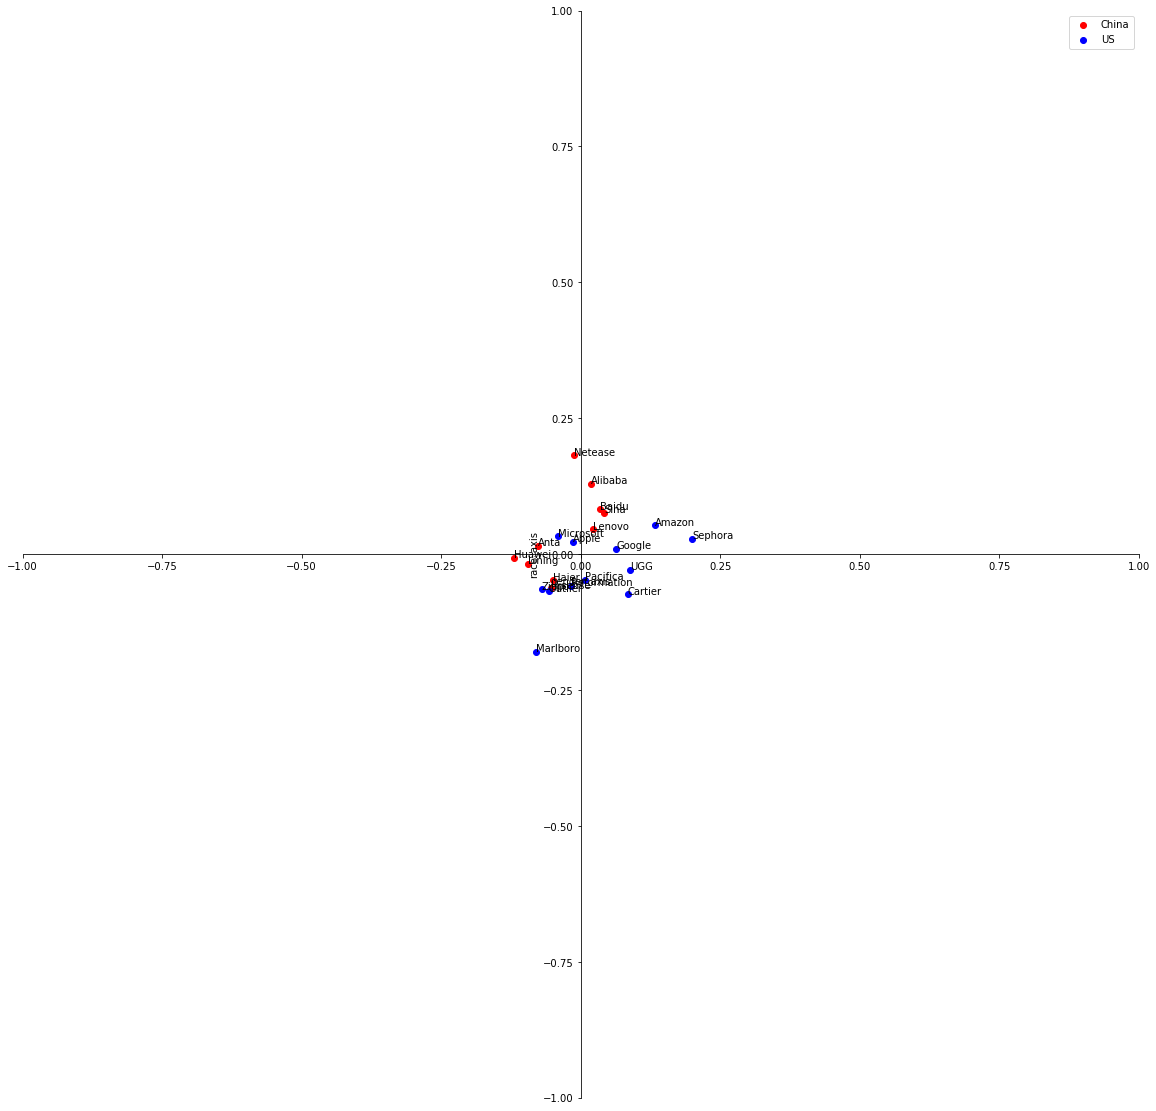

In [19]:
# plot using unit length
# project onto the gender-country plane
brands = brands_China + brands_US
gender_direction = gender_debias._B.reshape(-1,)
race_direction = race_debias._B.reshape(-1,)
c_gender_unit = []
c_race_unit = []
for brand in brands:
    vec = get_word_vector(brand, kv, mean)
    coordinate_gender = vec.dot(gender_direction) / (np.linalg.norm(vec) * np.linalg.norm(gender_direction))
    coordiante_race = vec.dot(race_direction) / (np.linalg.norm(vec) * np.linalg.norm(race_direction))
    c_gender_unit.append(coordinate_gender)
    c_race_unit.append(coordiante_race)

# plot on the gender-country 2D plane
fig2, ax2 = plt.subplots(1, 1, figsize=(20, 20))

ax2.spines['left'].set_position('zero')
ax2.spines['bottom'].set_position('zero')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')

ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_xlabel('gender_axis')
ax2.set_ylabel('race_axis')
split = len(brands_China)
ax2.scatter(x=c_gender_unit[:split], y=c_race_unit[:split], c='r', label='China')
ax2.scatter(x=c_gender_unit[split:], y=c_race_unit[split:], c='b', label='US')
brands = brands_China + brands_US
for i, brand in enumerate(brands):
    ax2.annotate(brand, (c_gender_unit[i], c_race_unit[i]))
ax2.legend()
fig2.savefig('../figures/gender_vs_race_unit_len.png')

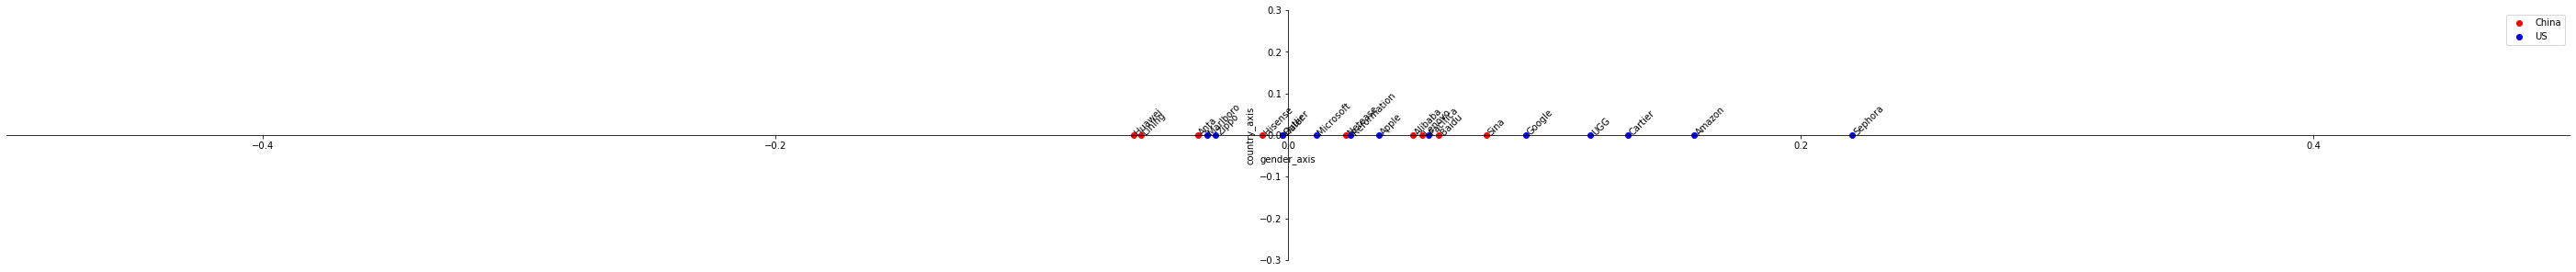

In [20]:
# debias race, check gender
brands = brands_China + brands_US
_, embedding_debiased, _ = race_debias.debiasing(words=brands, eq_sets=race_ds)

c_gender_unit_race_debiased = []
c_race_unit_race_debiased = []
for i, brand in enumerate(brands):
    coordinate_gender = embedding_debiased[i].dot(gender_direction) / (np.linalg.norm(embedding_debiased[i]) * np.linalg.norm(gender_direction))
    coordiante_race = embedding_debiased[i].dot(race_direction) / (np.linalg.norm(embedding_debiased[i]) * np.linalg.norm(race_direction))
    c_gender_unit_race_debiased.append(coordinate_gender)
    c_race_unit_race_debiased.append(coordiante_race)

# plot on the gender-country 2D plane
fig3, ax3 = plt.subplots(1, 1, figsize=(50, 5))

ax3.spines['left'].set_position('zero')
ax3.spines['bottom'].set_position('zero')
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')

ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_ticks_position('left')

ax3.set_xlim(-0.5, 0.5)
ax3.set_ylim(-0.3, 0.3)
ax3.set_xlabel('gender_axis')
ax3.set_ylabel('country_axis')
split = len(brands_China)
ax3.scatter(x=c_gender_unit_race_debiased[:split], y=c_race_unit_race_debiased[:split], c='r', label='China')
ax3.scatter(x=c_gender_unit_race_debiased[split:], y=c_race_unit_race_debiased[split:], c='b', label='US')
brands = brands_China + brands_US
for i, brand in enumerate(brands):
    ax3.annotate(brand, (c_gender_unit_race_debiased[i], c_race_unit_race_debiased[i]), rotation=45)
ax3.legend()
fig3.savefig('../figures/gender_vs_race_unit_len_race_debiased.png')